In [1]:
#Cab Fare Prediction:-
#### Problem Statement​ -
#You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected thehistorical data from your pilot project and now have a requirement to apply analytics forfare prediction. You need to design a system that predicts the fare amount for a cab ride in the city.

In [3]:
#loading the required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
from geopy.distance import great_circle
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



In [3]:
#The details of data attributes in the dataset are as follows:
#-  pickup_datetime - timestamp value indicating when the cab ride started.
#-  pickup_longitude - float for longitude coordinate of where the cab ride started.
#-  pickup_latitude - float for latitude coordinate of where the cab ride started.
#-  dropoff_longitude - float for longitude coordinate of where the cab ride ended.
#-  dropoff_latitude - float for latitude coordinate of where the cab ride ended.
#-  passenger_count - an integer indicating the number of passengers in the cab ride.

In [4]:
#predictive modeling machine learning project can be broken down into below workflow: 
#1. Prepare Problem 
#a) Load libraries b) Load dataset 
#2. Summarize Data a) Descriptive statistics b) Data visualizations 
#3. Prepare Data a) Data Cleaning b) Feature Selection c) Data Transforms 
#4. Evaluate Algorithms a) Split-out validation dataset b) Test options and evaluation metric c) Spot Check Algorithms d) Compare Algorithms 
#5. Improve Accuracy a) Algorithm Tuning b) Ensembles 
#6. Finalize Model a) Predictions on validation dataset b) Create standalone model on entire training dataset c) Save model for later use

In [4]:
#import the data
train = pd.read_csv('train_cab.csv',dtype={'fare_amount':np.float64},na_values={'fare_amount':'430-'})
test = pd.read_csv('test.csv')
data=[train,test]
for i in data:
    i['pickup_datetime']  = pd.to_datetime(i['pickup_datetime'],errors='coerce')

In [6]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [7]:
train.tail()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
16062,6.5,2014-12-12 07:41:00+00:00,-74.008820,40.718757,-73.998865,40.719987,1.0
16063,16.1,2009-07-13 07:58:00+00:00,-73.981310,40.781695,-74.014392,40.715527,2.0
16064,8.5,2009-11-11 11:19:07+00:00,-73.972507,40.753417,-73.979577,40.765495,1.0
16065,8.1,2010-05-11 23:53:00+00:00,-73.957027,40.765945,-73.981983,40.779560,1.0
16066,8.5,2011-12-14 06:24:33+00:00,-74.002111,40.729755,-73.983877,40.761975,NaN


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.7 KB


In [9]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [10]:
train.shape

(16067, 7)

In [11]:
train.nunique()

fare_amount            467
pickup_datetime      16020
pickup_longitude     13789
pickup_latitude      14241
dropoff_longitude    13887
dropoff_latitude     14263
passenger_count         27
dtype: int64

In [12]:
## EDA
#-  we will convert passenger_count into a categorical variable because passenger_count is not a continuous variable.
#-  passenger_count cannot take continous values. and also they are limited in number if its a cab.

In [5]:
cat_var=['passenger_count']
num_var=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_amount']

In [14]:
#Missing Value Analayis

In [6]:
train.isnull().sum()

fare_amount          25
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [16]:
missing_val=pd.DataFrame(train.isnull().sum())

In [17]:
missing_val=missing_val.reset_index()

In [18]:
missing_val=missing_val.rename(columns={'index':'Variables',0:'Missing_percentage'})

In [19]:
missing_val['Missing_percentage']=(missing_val['Missing_percentage']/len(train))*100

In [20]:
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_percentage
0,passenger_count,0.342317
1,fare_amount,0.155598
2,pickup_datetime,0.006224
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [7]:
# Missing values are less than 1% so we can delete NA values from our dataset
train=train.dropna()

In [22]:
#Graphical EDA - Data Visualization

In [23]:
#Data Visualization categorical columns:-

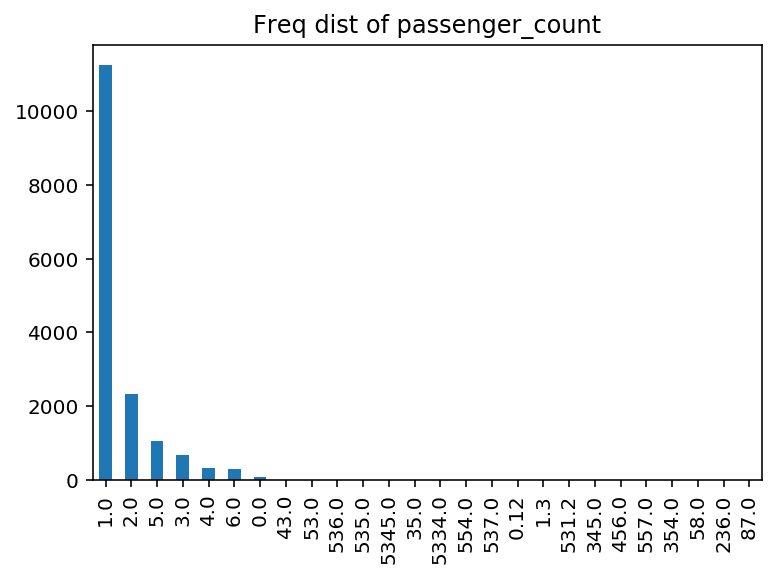

In [24]:
train['passenger_count'].value_counts().plot.bar(title='Freq dist of passenger_count')

In [25]:
#Data Visualization (univariate distribution) of the numerical columns

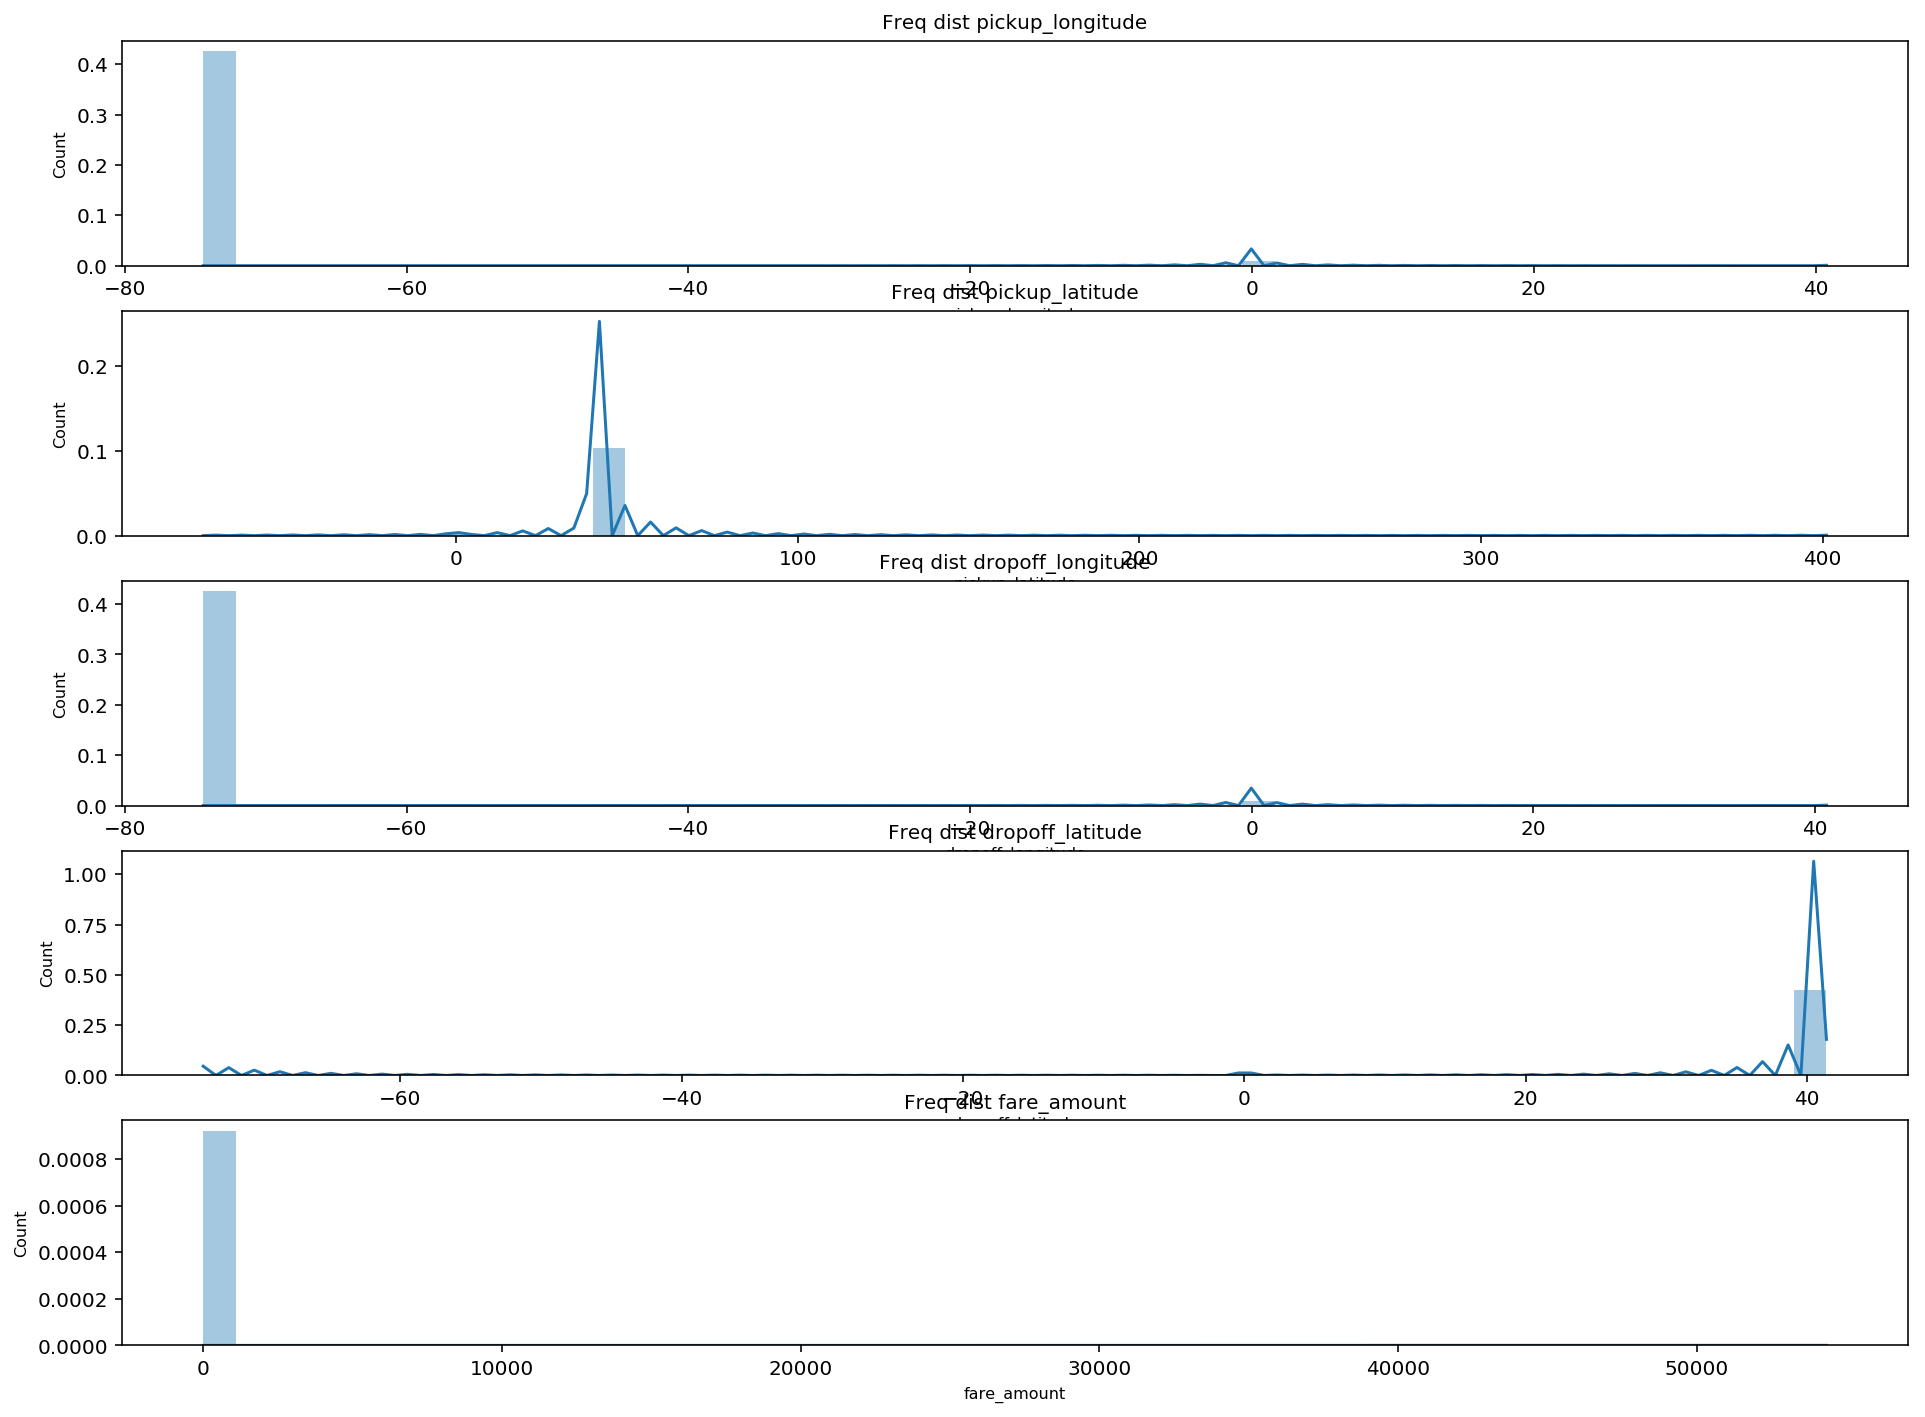

In [26]:
fig, ax = plt.subplots(len(num_var), figsize=(16,12))

for i, col_val in enumerate(num_var):
    

    sns.distplot(train[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

In [27]:
#Data Visualization (bivariate distribution) of the numerical columns

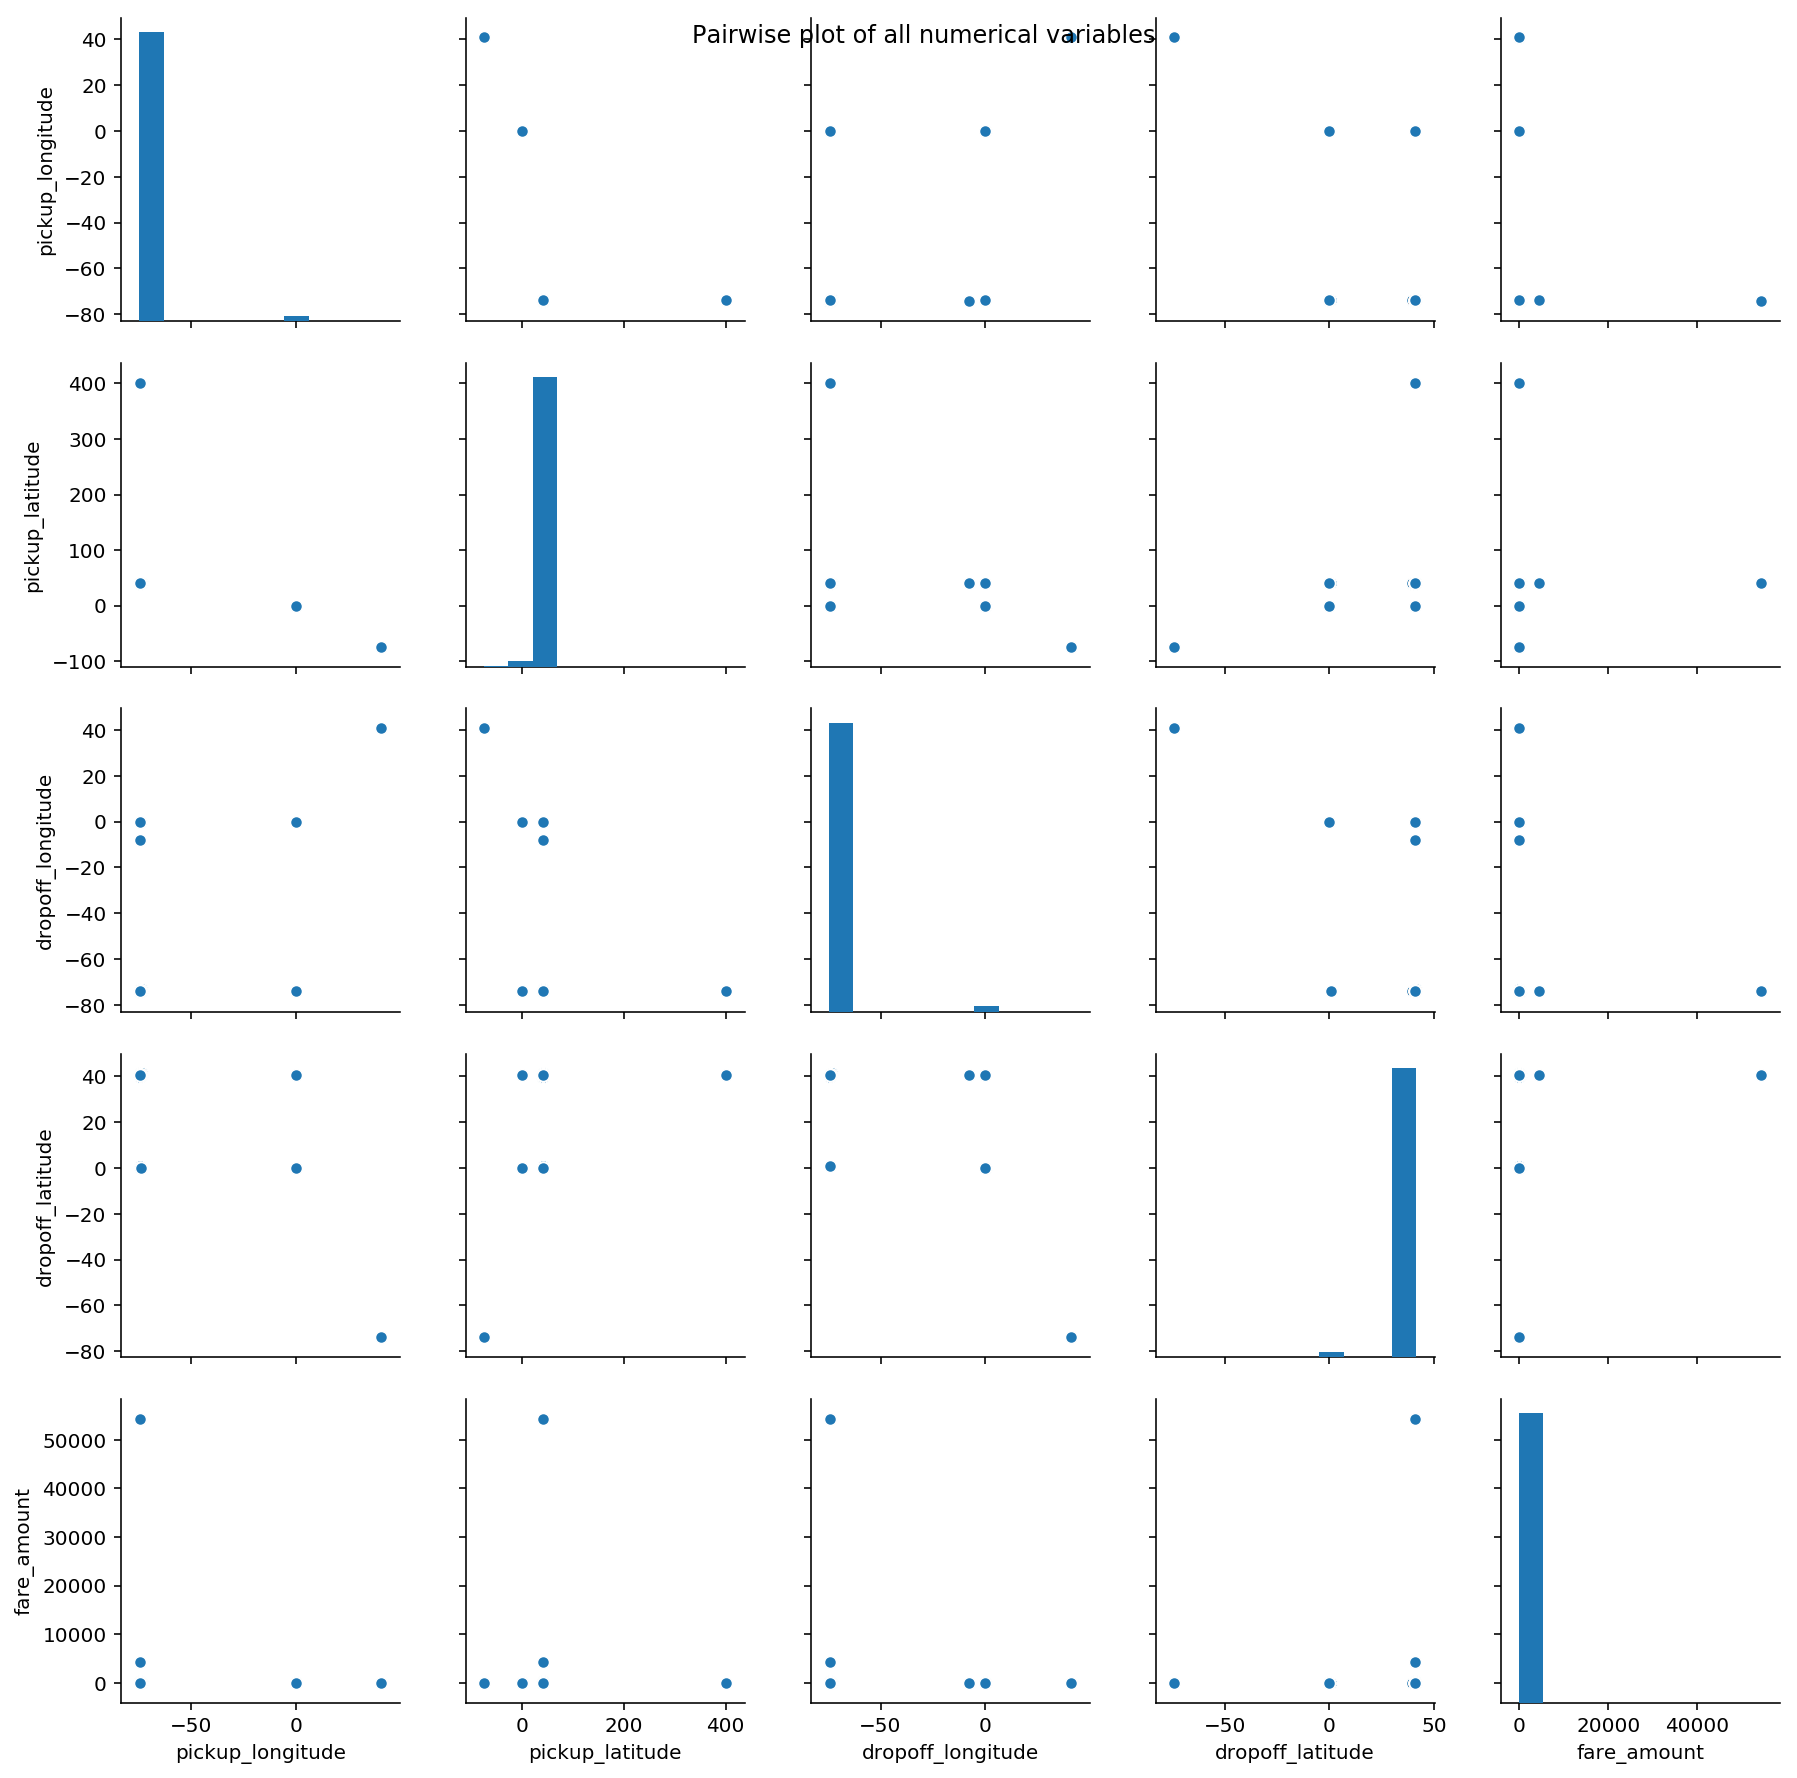

In [28]:
_ =sns.pairplot(data=train[num_var],kind='scatter',dropna=True)
_.fig.suptitle('Pairwise plot of all numerical variables')
# plt.savefig('Pairwise.png')
plt.show()

In [0]:
## Removing values which are not within desired range(outlier) depending upon basic understanding of dataset.

In [0]:
## 1.Fare amount has a negative value, which doesn't make sense. A price amount cannot be -ve and also cannot be 0. So we will remove these fields.


In [0]:
train['fare_amount'].describe()

In [0]:
sum(train['fare_amount']<1)

In [0]:
train[train['fare_amount']<1]

In [8]:
train = train.drop(train[train['fare_amount']<1].index, axis=0)
train.shape

(15981, 7)

In [0]:
#2.Passenger_count variable

# Number of passengers cannot be 0 and maximum number of passengers that can fit in a car is 6.

In [7]:
train['passenger_count']=train['passenger_count'].round().astype('object').astype('category',ordered=True)

In [10]:
train['passenger_count'].unique()

[1.0, 2.0, 3.0, 6.0, 5.0, 4.0]
Categories (6, float64): [1.0 < 2.0 < 3.0 < 4.0 < 5.0 < 6.0]

In [0]:
train['passenger_count'].value_counts()

In [0]:
test['passenger_count'].unique()

In [0]:
# => passenger_count variable conatins values which are equal to 0.
# => And test data does not contain passenger_count=0 . So if we feature engineer passenger_count of train dataset then it will create a dummy variable for passenger_count=0 which will be an extra feature compared to test dataset.
# => So, we will remove those 0 values.
# => Also, We will also remove those values which are greater than 6 because maximum number of passengers that can fit in a car is 6

In [9]:
train=train[ (train['passenger_count']<=6) & (train['passenger_count']>=1) ]
train.shape

(15904, 7)

In [10]:
sum(train['passenger_count']>6)

0

In [11]:
sum(train['passenger_count']<1)

0

In [0]:
# 3.Latitudes range from -90 to 90.Longitudes range from -180 to 180. Removing which does not satisfy these ranges

In [12]:
#Excluding values other than these ranges
# for latitude range : -90<value<90
#for longitude raange : -180<value<180
train=train.drop(((train[train['pickup_longitude']<-180]) | (train[train['pickup_longitude']>180])).index,axis=0)
train=train.drop(((train[train['dropoff_longitude']<-180]) | (train[train['dropoff_longitude']>180])).index,axis=0)
train=train.drop(((train[train['pickup_latitude']<-90])| (train[train['pickup_latitude']>90])).index,axis=0)
train=train.drop(((train[train['dropoff_latitude']<-90])| (train[train['dropoff_latitude']>90])).index,axis=0)
train.shape

(15903, 7)

In [13]:
#Removing observations whoose pickup and dropoff latitude and londitude are same
train = train[(train['pickup_latitude'] != train['dropoff_latitude']) & (train['pickup_longitude'] != train['dropoff_longitude'])]
train.shape

(15444, 7)

In [0]:
### Outlier Analysis using Boxplot


In [0]:
#Univariate Boxplots: Boxplots for all Numerical Variables including target variable.

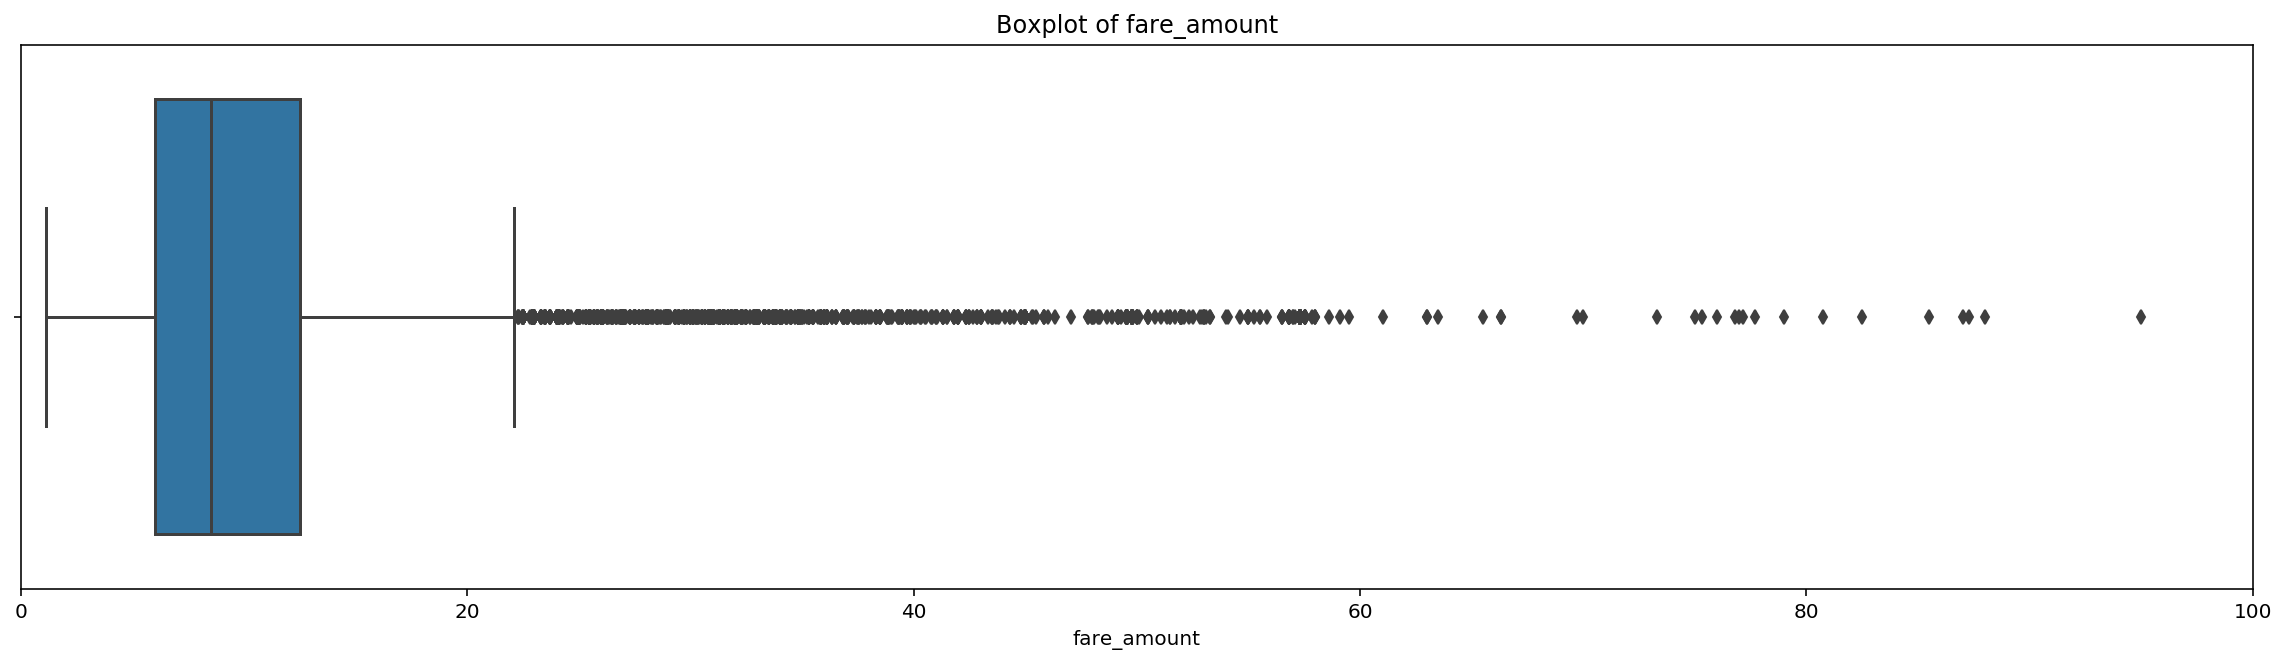

In [35]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of fare_amount')
# plt.savefig('bp of fare_amount.png')
plt.show()

In [0]:
sum(train['fare_amount']<22.5)/len(train['fare_amount'])*100

In [0]:
#Bivariate Boxplots: Boxplot for Numerical Variable Vs Categorical Variable.

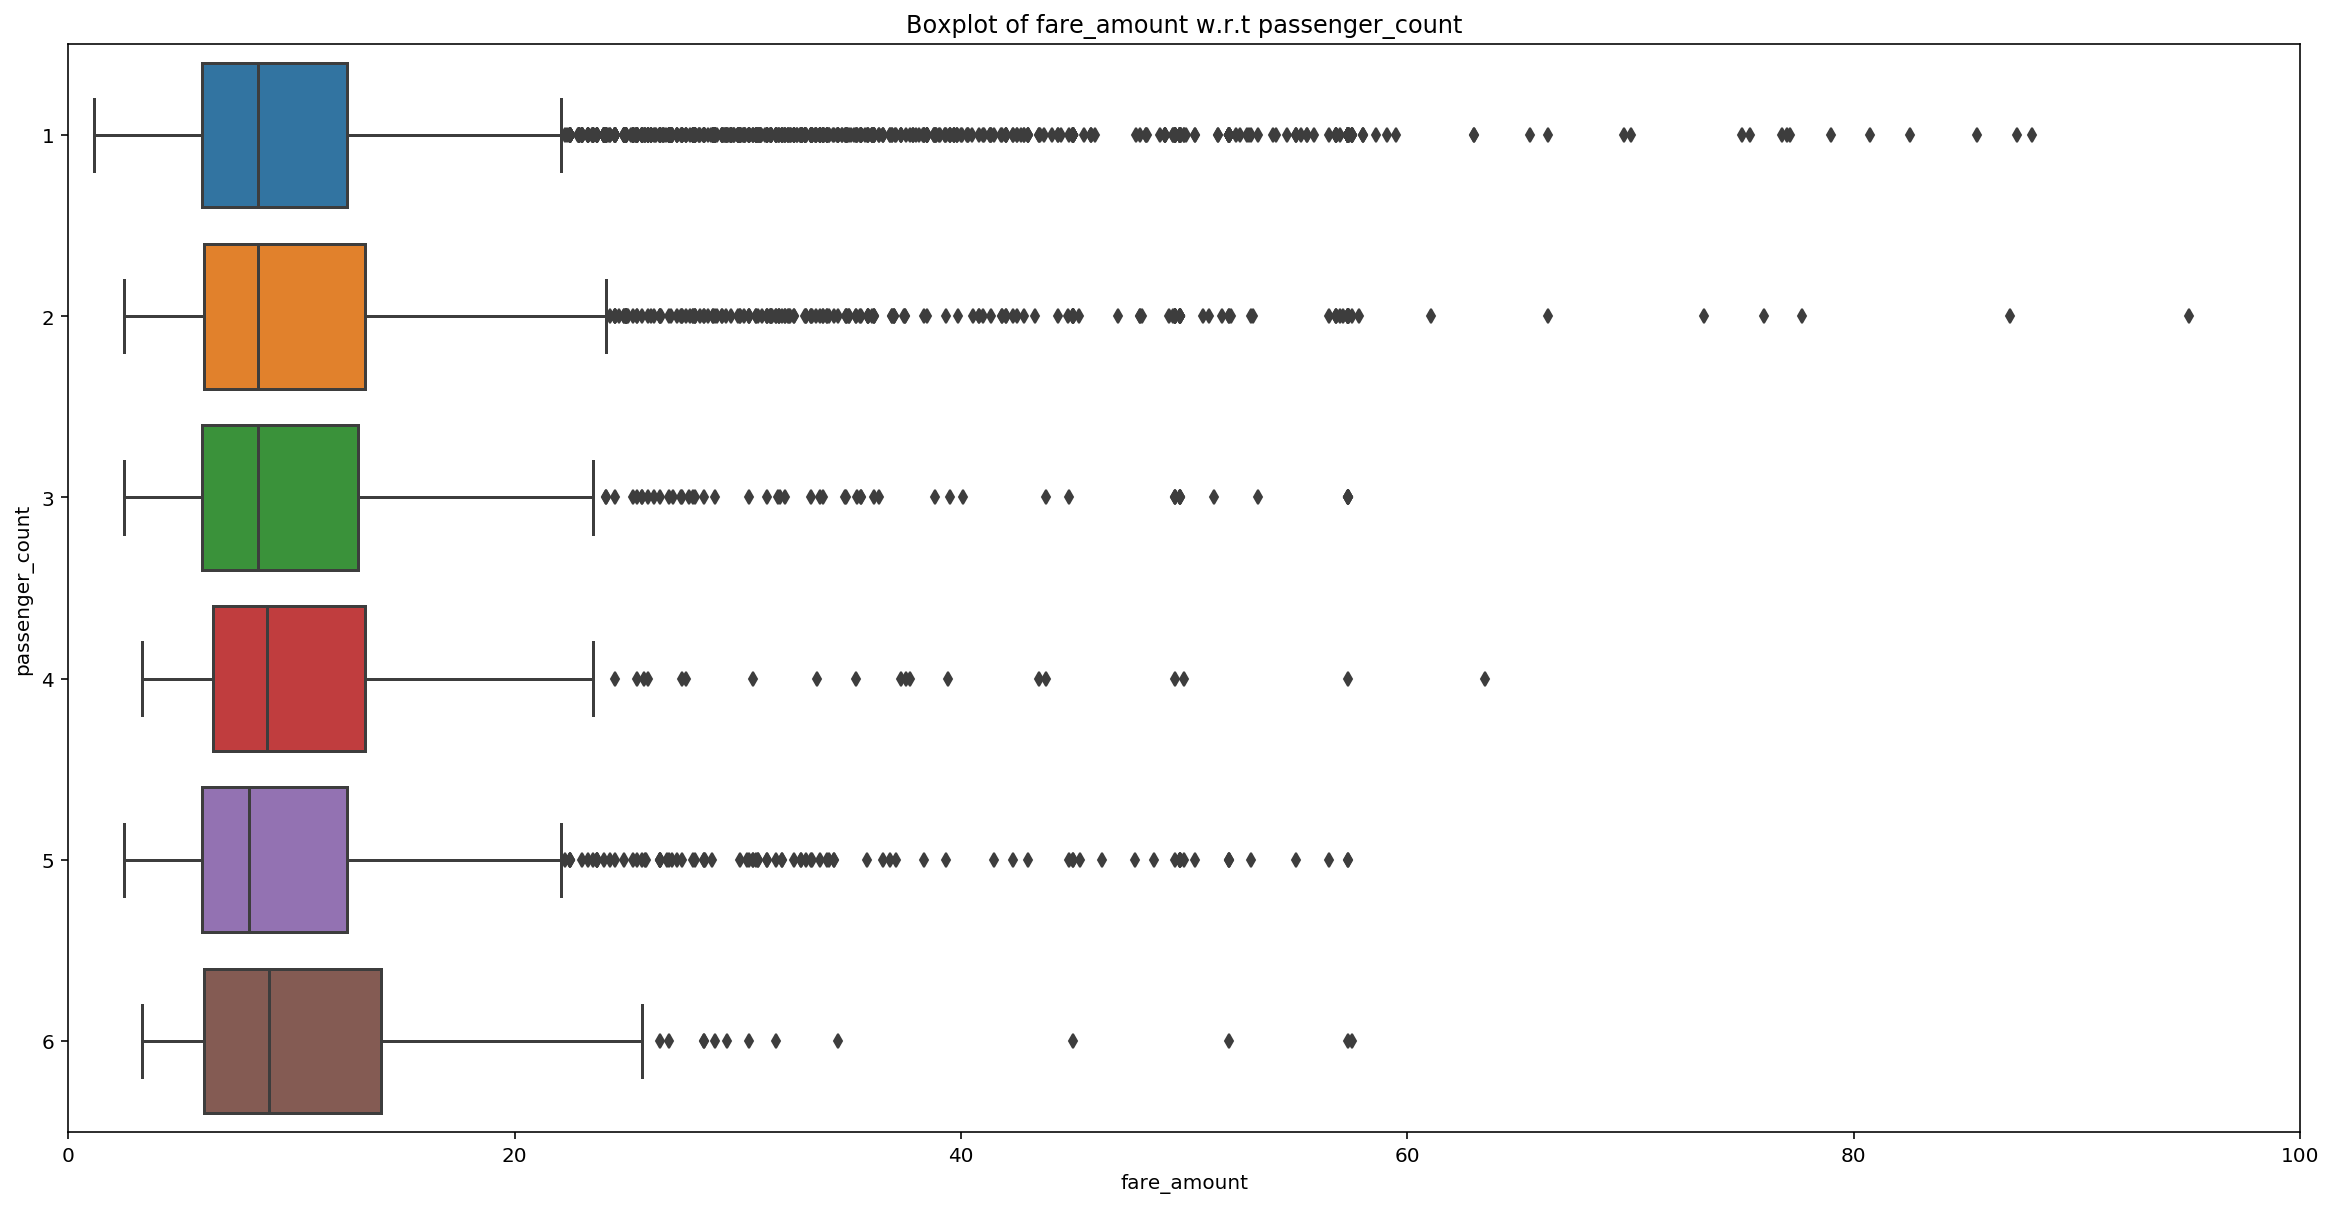

In [36]:
plt.figure(figsize=(20,10))
plt.xlim(0,100)
_ = sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of fare_amount w.r.t passenger_count')
# plt.savefig('Boxplot of fare_amount w.r.t passenger_count.png')
plt.show()

In [0]:
## Outlier Treatment
-  As we can see from the above Boxplots there are outliers in the train dataset.
-  Reconsider pickup_longitude,etc.

In [14]:
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(train[col], [75 ,25])
    print(q75,q25)
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(minimum,maximum)
    #Replace with NA
    train.loc[train[col] < minimum,col] = np.nan
    train.loc[train[col] > maximum,col] = np.nan

In [15]:
for i in num_var:
    outlier_treatment('fare_amount')
    outlier_treatment('pickup_longitude')
    outlier_treatment('pickup_latitude')
    outlier_treatment('dropoff_longitude')
    outlier_treatment('dropoff_latitude')

12.5 6.0
-3.75 22.25


-73.9681235 -73.9923709575
-74.02874214375 -73.93175231375001
40.767799 40.736542824999994
40.689658562499986 40.8146832625
-73.96544625 -73.99136425
-74.03024125000002 -73.92656925
40.7683105 40.73626324999999
40.688192374999986 40.816381375000006
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


In [16]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,1348
pickup_datetime,0
pickup_longitude,783
pickup_latitude,495
dropoff_longitude,898
dropoff_latitude,737
passenger_count,0


In [17]:
train['fare_amount'].fillna((train['fare_amount'].mean()), inplace=True)
train['pickup_longitude'].fillna((train['pickup_longitude'].mean()), inplace=True)
train['pickup_latitude'].fillna((train['pickup_latitude'].mean()), inplace=True)
train['dropoff_longitude'].fillna((train['dropoff_longitude'].mean()), inplace=True)
train['dropoff_latitude'].fillna((train['dropoff_latitude'].mean()), inplace=True)

In [18]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [0]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

In [0]:
#Feature Engineering

In [0]:
#1.Feature Engineering for timestamp variable
# ->we will derive new features from pickup_datetime variable
# ->new features will be year,month,day_of_week,hour

In [19]:
data = [train,test]
for i in data:
    i["year"] = i["pickup_datetime"].apply(lambda row: row.year)
    i["month"] = i["pickup_datetime"].apply(lambda row: row.month)
#     i["day_of_month"] = i["pickup_datetime"].apply(lambda row: row.day)
    i["day_of_week"] = i["pickup_datetime"].apply(lambda row: row.dayofweek)
    i["hour"] = i["pickup_datetime"].apply(lambda row: row.hour)

In [0]:
#Now we will use month,day_of_week,hour to derive new features like sessions in a day,seasons in a year,week:weekend/weekday

In [20]:
def f(x):
    ''' for sessions in a day using hour column '''
    if (x >=5) and (x <= 11):
        return 'morning'
    elif (x >=12) and (x <=16 ):
        return 'afternoon'
    elif (x >= 17) and (x <= 20):
        return'evening'
    elif (x >=21) and (x <= 23) :
        return 'night_PM'
    elif (x >=0) and (x <=4):
        return'night_AM'

In [21]:
def h(x):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [22]:
def g(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

In [23]:
train['session'] = train['hour'].apply(f)
test['session'] = test['hour'].apply(f)
train['seasons'] = train['month'].apply(g)
test['seasons'] = test['month'].apply(g)
train['week'] = train['day_of_week'].apply(h)
test['week'] = test['day_of_week'].apply(h)

In [24]:
train.shape

(15444, 14)

In [0]:
#2.Feature Engineering for passenger_count variable
# -> Because models in scikit learn require numerical input,if dataset contains categorical variables then we have to encode them.
# -> We will use one hot encoding technique for passenger_count variable.

In [27]:
train['passenger_count']=train['passenger_count'].astype('int').round().astype('object').astype('category')

In [28]:
train['passenger_count'].describe()

count     15444
unique        6
top           1
freq      10896
Name: passenger_count, dtype: int64

In [29]:
#Creating dummies for each variable in passenger_count and merging dummies dataframe to both train and test dataframe
temp = pd.get_dummies(train['passenger_count'], prefix = 'passenger_count')
train = train.join(temp)
temp = pd.get_dummies(test['passenger_count'], prefix = 'passenger_count')
test = test.join(temp)
temp = pd.get_dummies(train['seasons'], prefix = 'season')
train = train.join(temp)
temp = pd.get_dummies(test['seasons'], prefix = 'season')
test = test.join(temp)
temp = pd.get_dummies(train['week'], prefix = 'week')
train = train.join(temp)
temp = pd.get_dummies(test['week'], prefix = 'week')
test = test.join(temp)
temp = pd.get_dummies(train['session'], prefix = 'session')
train = train.join(temp)
temp = pd.get_dummies(test['session'], prefix = 'session')
test = test.join(temp)
temp = pd.get_dummies(train['year'], prefix = 'year')
train = train.join(temp)
temp = pd.get_dummies(test['year'], prefix = 'year')
test = test.join(temp)

In [30]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,4.5,2009-06-15 17:26:21+00:00,-73.981716,40.721319,-73.980097,40.712278,1,2009,6,0,...,0,0,0,1,0,0,0,0,0,0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,0,0,1,0,0,0,0,0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,1,0,0,0,1,0,0,0,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,1,0,0,0,0,1,0,0,0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,1,0,0,0,1,0,0,0,0,0


In [31]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,1,0,0,0,0,1,0,0,0,0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0


In [0]:
#we will drop one column from each one-hot-encoded variables

In [32]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015'],
      dtype='object')

In [33]:
train=train.drop(['passenger_count_1','season_fall','week_weekday','session_afternoon','year_2009'],axis=1)
test=test.drop(['passenger_count_1','season_fall','week_weekday','session_afternoon','year_2009'],axis=1)

In [0]:
#3.Feature Engineering for latitude and longitude variable
# -> As we have latitude and longitude data for pickup and dropoff, we will find the distance the cab travelled from pickup and dropoff location.

In [54]:
def haversine(coord1, coord2):
#     '''Calculate distance the cab travelled from pickup and dropoff location using the Haversine Formula'''
     data = [train, test]
     for i in data:
         lon1, lat1 = coord1
         lon2, lat2 = coord2
         R = 6371000  # radius of Earth in meters
         phi_1 = np.radians(i[lat1])
         phi_2 = np.radians(i[lat2])
         delta_phi = np.radians(i[lat2] - i[lat1])
         delta_lambda = np.radians(i[lon2] - i[lon1])
         a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
         meters = R * c  # output distance in meters
         km = meters / 1000.0  # output distance in kilometers
         miles = round(km, 3)/1.609344
         i['distance'] = miles
     print(f"Distance: {miles} miles")
     return miles

In [0]:
#haversine(['pickup_longitude','pickup_latitude'],['dropoff_longitude','dropoff_latitude'])

In [34]:
# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
data = [train, test]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)
    i['geodesic']=i.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)

In [35]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,4.5,2009-06-15 17:26:21+00:00,-73.981716,40.721319,-73.980097,40.712278,1,2009,6,0,...,0,0,0,0,0,0,0,0,0.630406,0.629618
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,1,0,0,0,0,0,5.250677,5.246511
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,1,0,0,1,0,0,0,0,0.863412,0.863167
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,1,0,0,0,1,0,0,0,1.739388,1.737223
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,0,0,1,0,0,0,0,0,1.242220,1.241710


In [36]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.443609,1.442197
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.507047,1.506080
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,0,0,0,1,0,0,0,0,0.384398,0.384120
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,1.218531,1.217683
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,3.347519,3.344737


In [0]:
#As Vincenty is more accurate than haversine. Also vincenty is prefered for short distances.Therefore we will drop great_circle. we will drop them together with other variables which were used to feature engineer.

In [0]:
#pd.DataFrame(train.isna().sum())

In [0]:
#We will remove the variables which were used to feature engineer new variables

In [29]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'great_circle', 'geodesic'],
      dtype='object')

In [37]:
train=train.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)
test=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)

In [38]:
train.shape,test.shape

((15444, 21), (9914, 20))

In [32]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [33]:
test.columns

Index(['passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

In [39]:
train.head()

,fare_amount,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_spring,season_summer,season_winter,week_weekend,...,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,4.5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.629618
1,16.9,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,5.246511
2,5.7,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0.863167
3,7.7,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1.737223
4,5.3,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1.241710


In [40]:
test.head()

,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_spring,season_summer,season_winter,week_weekend,session_evening,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.442197
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.506080
2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0.384120
3,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1.217683
4,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,3.344737


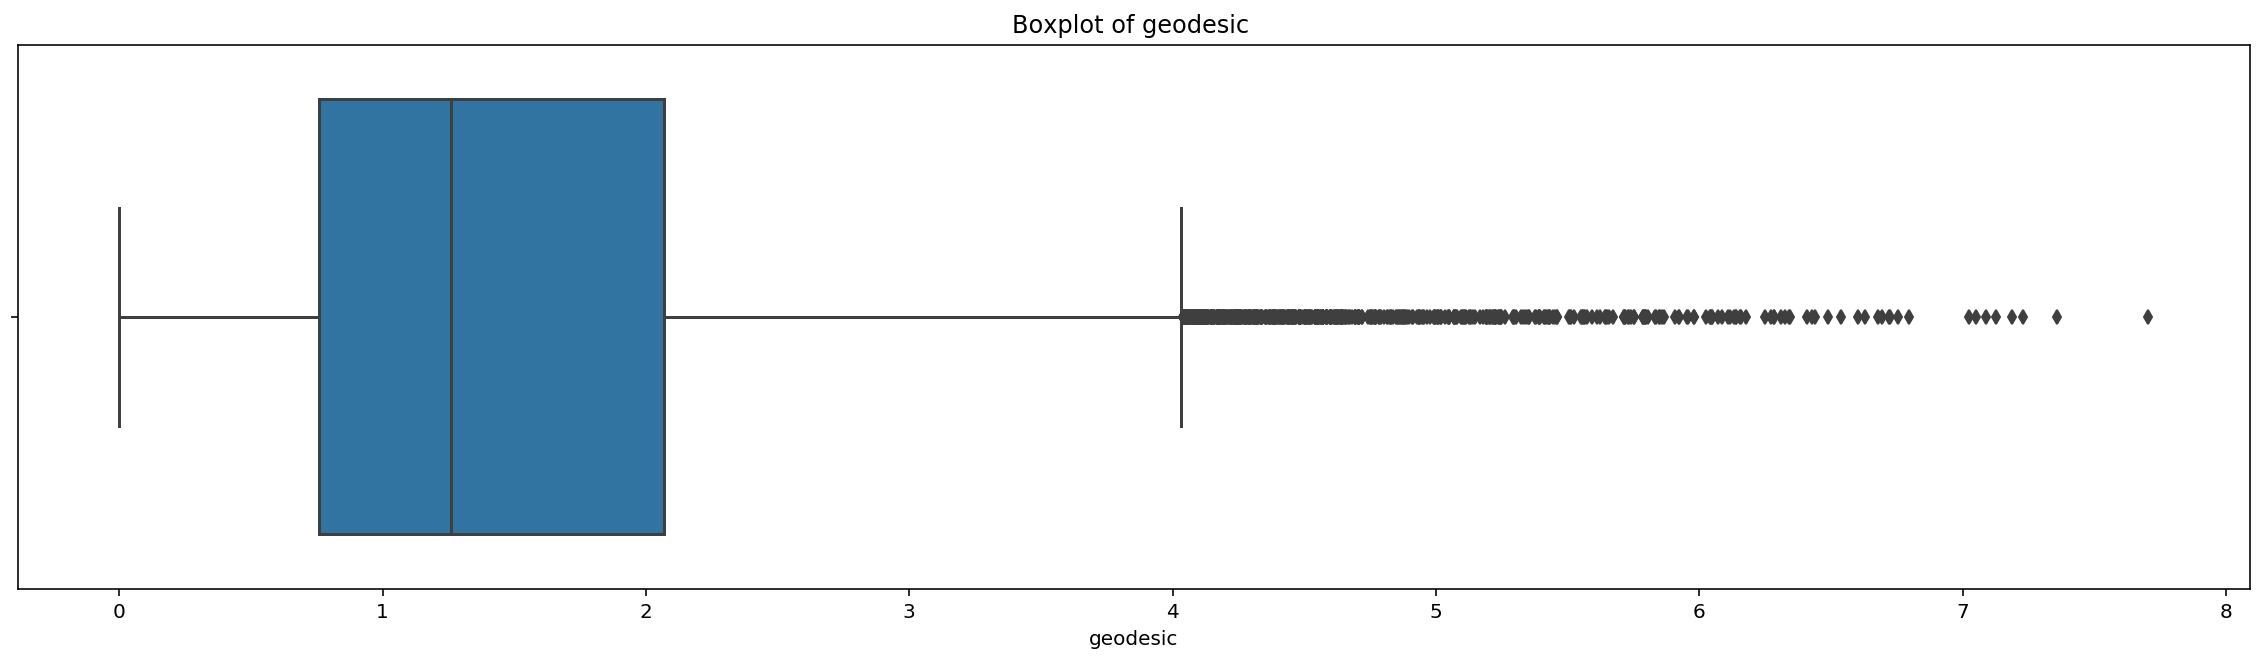

In [41]:
plt.figure(figsize=(20,5)) 
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

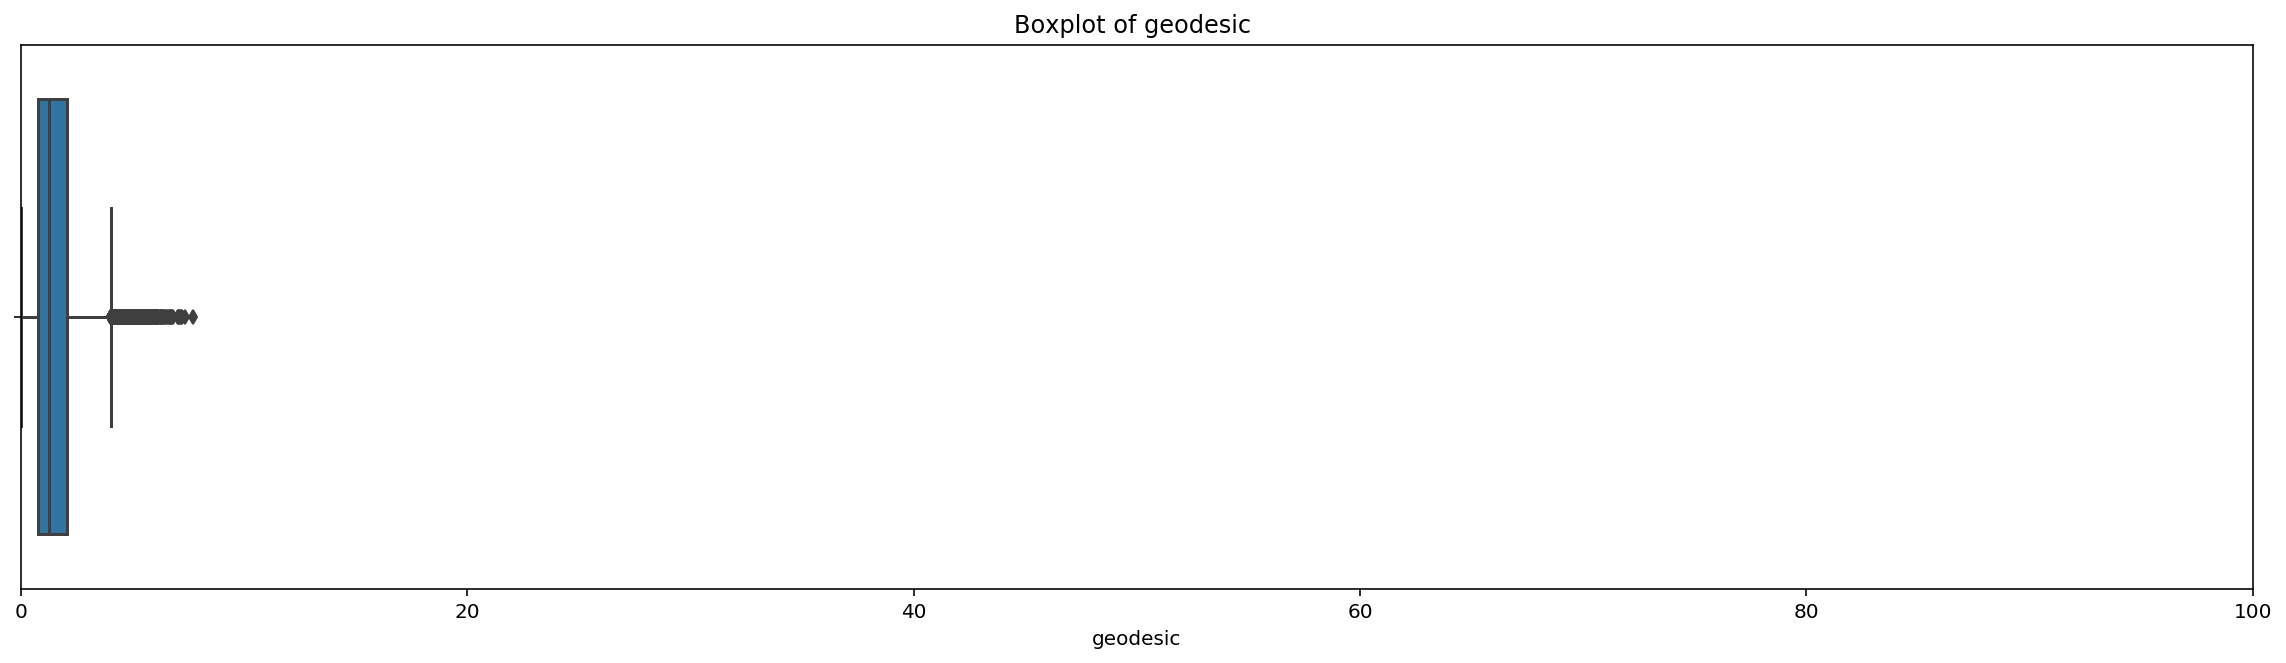

In [42]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

In [43]:
outlier_treatment('geodesic')

2.0679799869903386 0.7583375055600134
-1.2061262165854743 4.032443709135826


In [39]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
season_spring,0
season_summer,0
season_winter,0
week_weekend,0


In [44]:
train['geodesic'].fillna((train['geodesic'].mean()), inplace=True)

In [0]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

In [47]:
#pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
season_spring,0
season_summer,0
season_winter,0
week_weekend,0


In [0]:
#Feature Selection

In [0]:
# 1.Correlation Analysis
# -> Statistically correlated: features move together directionally.
# -> Linear models assume feature independence.
# -> And if features are correlated that could introduce bias into our models.

In [48]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [49]:
cat_var=['passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_spring', 'season_summer',
       'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015']
num_var=['fare_amount','geodesic']
train[cat_var]=train[cat_var].apply(lambda x: x.astype('category') )
test[cat_var]=test[cat_var].apply(lambda x: x.astype('category') ) 

In [0]:
# We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.

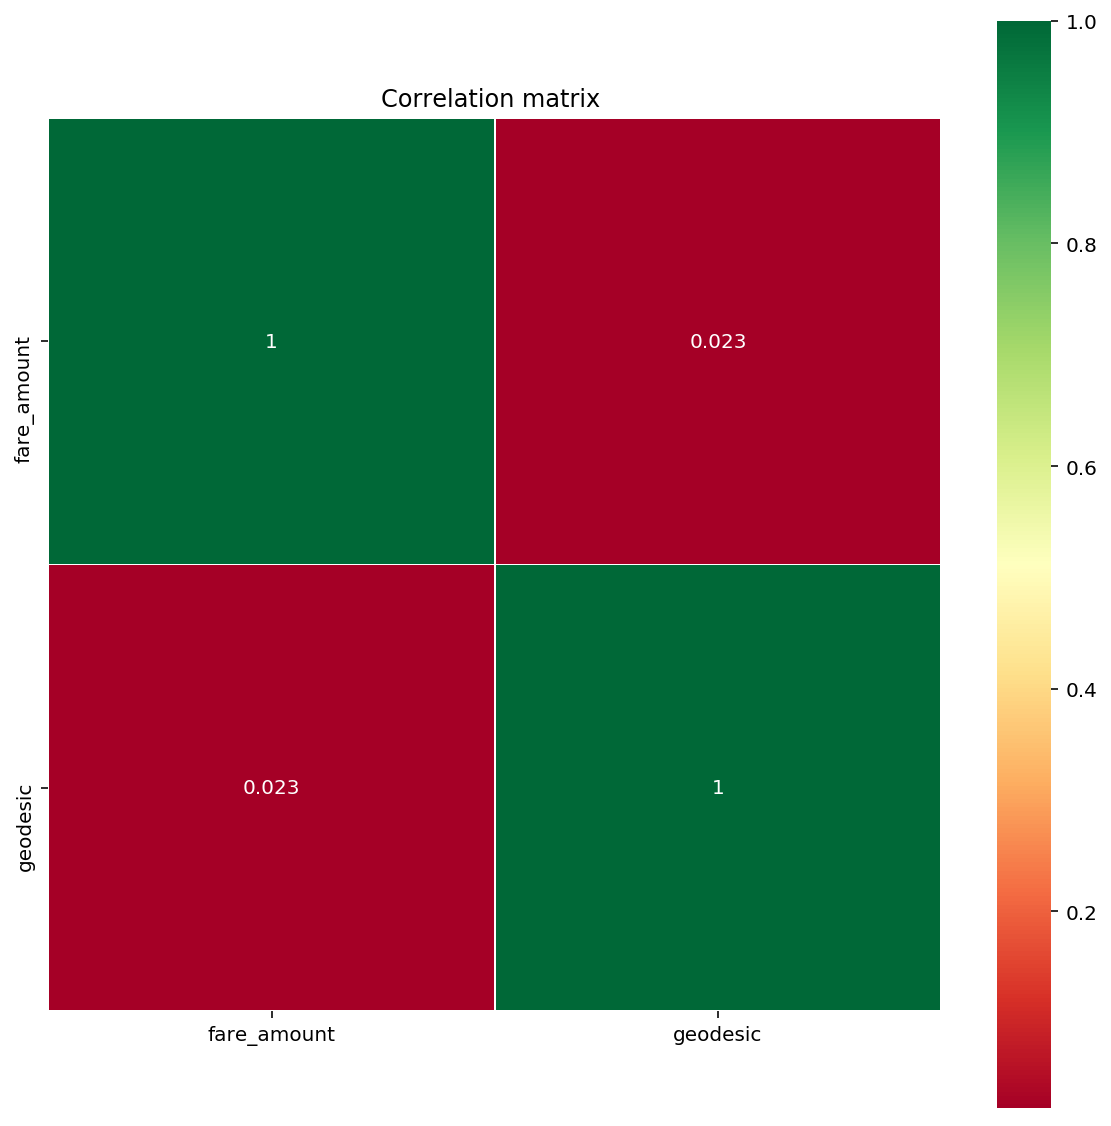

In [43]:
# heatmap using correlation matrix
plt.figure(figsize=(10,10))
_ = sns.heatmap(train[num_var].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')
# plt.savefig('correlation.png')
plt.show()

In [0]:
# As we can see from above correlation plot fare_amount and geodesic is highly correlated to each other.
# As fare_amount is the target variable and ‘geodesic’ is independent variable we will keep ‘geodesic’ because it will help to explain variation in fare_amount.

In [0]:
# Chi-square test of Independence for Categorical Variables/Features
# Hypothesis testing :
Null Hypothesis: 2 variables are dependent.
Alternate Hypothesis: 2 variables are not independent.
# If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
# And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent.
# There should be no dependencies between Independent variables.
# So we will remove that variable whose p-value with other variable is low than 0.05.
# And we will keep that variable whose p-value with other variable is high than 0.05

In [44]:
#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(train[i], train[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

passenger_count_2 and passenger_count_3 are dependent on each other with 3.880874598247121e-27 ----Remove
passenger_count_2 and passenger_count_4 are dependent on each other with 1.6562820541330264e-13 ----Remove


passenger_count_2 and passenger_count_5 are dependent on each other with 2.5495928011449748e-42 ----Remove


passenger_count_2 and passenger_count_6 are dependent on each other with 1.3412739135599215e-12 ----Remove
passenger_count_2 and season_spring are independent on each other with 0.9885218179404535 ----Keep
passenger_count_2 and season_summer are dependent on each other with 0.02156910570304293 ----Remove
passenger_count_2 and season_winter are independent on each other with 0.5084474478316219 ----Keep
passenger_count_2 and week_weekend are dependent on each other with 1.1261813904053738e-10 ----Remove


passenger_count_2 and session_evening are dependent on each other with 0.027904227888922415 ----Remove
passenger_count_2 and session_morning are dependent on each other with 1.422804795010472e-16 ----Remove
passenger_count_2 and session_night_AM are dependent on each other with 0.018044382140082055 ----Remove
passenger_count_2 and session_night_PM are dependent on each other with 2.0689977346780605e-05 ----Remove
passenger_count_2 and year_2010 are independent on each other with 0.7926500911740486 ----Keep


passenger_count_2 and year_2011 are dependent on each other with 0.008616045011099117 ----Remove
passenger_count_2 and year_2012 are independent on each other with 0.9873349373712309 ----Keep
passenger_count_2 and year_2013 are independent on each other with 0.09350324953183572 ----Keep
passenger_count_2 and year_2014 are independent on each other with 0.22976123141096655 ----Keep
passenger_count_2 and year_2015 are independent on each other with 0.8746529815658493 ----Keep


passenger_count_3 and passenger_count_2 are dependent on each other with 3.880874598247121e-27 ----Remove
passenger_count_3 and passenger_count_4 are dependent on each other with 0.0002639310169297409 ----Remove


passenger_count_3 and passenger_count_5 are dependent on each other with 6.300119575065566e-12 ----Remove
passenger_count_3 and passenger_count_6 are dependent on each other with 0.00046483380198887543 ----Remove
passenger_count_3 and season_spring are independent on each other with 0.24486068017070495 ----Keep


passenger_count_3 and season_summer are independent on each other with 0.12611331226651634 ----Keep
passenger_count_3 and season_winter are independent on each other with 0.4631141469510328 ----Keep
passenger_count_3 and week_weekend are dependent on each other with 4.3217128356941136e-06 ----Remove
passenger_count_3 and session_evening are independent on each other with 0.7483504924869417 ----Keep
passenger_count_3 and session_morning are dependent on each other with 0.0002565919524368262 ----Remove
passenger_count_3 and session_night_AM are dependent on each other with 0.0028634830987033784 ----Remove
passenger_count_3 and session_night_PM are dependent on each other with 0.017461381217427373 ----Remove


passenger_count_3 and year_2010 are independent on each other with 0.25824878333578544 ----Keep
passenger_count_3 and year_2011 are independent on each other with 0.6854066193312632 ----Keep
passenger_count_3 and year_2012 are independent on each other with 0.6568420816520042 ----Keep
passenger_count_3 and year_2013 are independent on each other with 0.30446767271443165 ----Keep
passenger_count_3 and year_2014 are independent on each other with 0.1085086507062926 ----Keep
passenger_count_3 and year_2015 are independent on each other with 0.6719657539125135 ----Keep


passenger_count_4 and passenger_count_2 are dependent on each other with 1.6562820541330264e-13 ----Remove
passenger_count_4 and passenger_count_3 are dependent on each other with 0.0002639310169297409 ----Remove


passenger_count_4 and passenger_count_5 are dependent on each other with 3.0920025146415887e-06 ----Remove
passenger_count_4 and passenger_count_6 are dependent on each other with 0.021535284814006603 ----Remove
passenger_count_4 and season_spring are independent on each other with 0.19298492392624872 ----Keep
passenger_count_4 and season_summer are independent on each other with 0.2564235088079283 ----Keep


passenger_count_4 and season_winter are dependent on each other with 0.03140516626398274 ----Remove
passenger_count_4 and week_weekend are dependent on each other with 1.155686675227025e-05 ----Remove
passenger_count_4 and session_evening are independent on each other with 0.9997012671768705 ----Keep
passenger_count_4 and session_morning are dependent on each other with 4.1268196543664704e-05 ----Remove
passenger_count_4 and session_night_AM are dependent on each other with 0.0014491086358962555 ----Remove
passenger_count_4 and session_night_PM are independent on each other with 0.439719976162414 ----Keep


passenger_count_4 and year_2010 are independent on each other with 0.48618768616980845 ----Keep
passenger_count_4 and year_2011 are independent on each other with 0.28664139778121855 ----Keep
passenger_count_4 and year_2012 are independent on each other with 0.7605780157360365 ----Keep
passenger_count_4 and year_2013 are independent on each other with 0.6740250852412275 ----Keep
passenger_count_4 and year_2014 are independent on each other with 0.9047163614705267 ----Keep
passenger_count_4 and year_2015 are independent on each other with 0.9253250081468951 ----Keep


passenger_count_5 and passenger_count_2 are dependent on each other with 2.5495928011449748e-42 ----Remove
passenger_count_5 and passenger_count_3 are dependent on each other with 6.300119575065566e-12 ----Remove


passenger_count_5 and passenger_count_4 are dependent on each other with 3.0920025146415887e-06 ----Remove
passenger_count_5 and passenger_count_6 are dependent on each other with 7.457854590735625e-06 ----Remove


passenger_count_5 and season_spring are dependent on each other with 0.03712882792382106 ----Remove
passenger_count_5 and season_summer are independent on each other with 0.9001396970275477 ----Keep
passenger_count_5 and season_winter are independent on each other with 0.27260550450749366 ----Keep


passenger_count_5 and week_weekend are independent on each other with 0.9836876146696336 ----Keep
passenger_count_5 and session_evening are independent on each other with 0.6198143348889662 ----Keep
passenger_count_5 and session_morning are independent on each other with 0.8239917469853544 ----Keep
passenger_count_5 and session_night_AM are independent on each other with 0.643897872355125 ----Keep
passenger_count_5 and session_night_PM are independent on each other with 0.7129692047887988 ----Keep
passenger_count_5 and year_2010 are dependent on each other with 0.004884785498888652 ----Remove


passenger_count_5 and year_2011 are independent on each other with 0.17696803399868244 ----Keep
passenger_count_5 and year_2012 are independent on each other with 0.24168863496316867 ----Keep
passenger_count_5 and year_2013 are dependent on each other with 0.013777214205450314 ----Remove
passenger_count_5 and year_2014 are dependent on each other with 0.0003388376421704987 ----Remove
passenger_count_5 and year_2015 are dependent on each other with 0.000220953516877017 ----Remove


passenger_count_6 and passenger_count_2 are dependent on each other with 1.3412739135599215e-12 ----Remove


passenger_count_6 and passenger_count_3 are dependent on each other with 0.00046483380198887543 ----Remove


passenger_count_6 and passenger_count_4 are dependent on each other with 0.021535284814006603 ----Remove


passenger_count_6 and passenger_count_5 are dependent on each other with 7.457854590735625e-06 ----Remove
passenger_count_6 and season_spring are independent on each other with 0.8624157315219587 ----Keep
passenger_count_6 and season_summer are independent on each other with 0.8963147506825618 ----Keep


passenger_count_6 and season_winter are independent on each other with 0.3904903716320045 ----Keep
passenger_count_6 and week_weekend are independent on each other with 0.7604818978745929 ----Keep
passenger_count_6 and session_evening are independent on each other with 0.4570496277410452 ----Keep


passenger_count_6 and session_morning are independent on each other with 0.7272856192803814 ----Keep
passenger_count_6 and session_night_AM are independent on each other with 0.8288092395846891 ----Keep
passenger_count_6 and session_night_PM are independent on each other with 0.318836785505026 ----Keep


passenger_count_6 and year_2010 are dependent on each other with 4.968297624065672e-09 ----Remove
passenger_count_6 and year_2011 are dependent on each other with 2.7334555120325144e-05 ----Remove
passenger_count_6 and year_2012 are dependent on each other with 0.028318768642273298 ----Remove
passenger_count_6 and year_2013 are dependent on each other with 6.790055314834625e-09 ----Remove


passenger_count_6 and year_2014 are dependent on each other with 1.8172342453134513e-06 ----Remove
passenger_count_6 and year_2015 are dependent on each other with 1.7224539196962448e-06 ----Remove
season_spring and passenger_count_2 are independent on each other with 0.9885218179404535 ----Keep


season_spring and passenger_count_3 are independent on each other with 0.24486068017070495 ----Keep
season_spring and passenger_count_4 are independent on each other with 0.19298492392624872 ----Keep


season_spring and passenger_count_5 are dependent on each other with 0.03712882792382106 ----Remove
season_spring and passenger_count_6 are independent on each other with 0.8624157315219587 ----Keep


season_spring and season_summer are dependent on each other with 0.0 ----Remove


season_spring and season_winter are dependent on each other with 0.0 ----Remove
season_spring and week_weekend are independent on each other with 0.659017663887979 ----Keep
season_spring and session_evening are independent on each other with 0.8010521057190065 ----Keep
season_spring and session_morning are independent on each other with 0.05901517009965523 ----Keep
season_spring and session_night_AM are independent on each other with 0.5948386358497064 ----Keep


season_spring and session_night_PM are independent on each other with 0.608061289264885 ----Keep
season_spring and year_2010 are independent on each other with 0.1970616894600986 ----Keep
season_spring and year_2011 are independent on each other with 0.12068607890700066 ----Keep
season_spring and year_2012 are dependent on each other with 0.0007573591981238606 ----Remove
season_spring and year_2013 are dependent on each other with 0.026184861734220553 ----Remove
season_spring and year_2014 are independent on each other with 0.07095545547458673 ----Keep
season_spring and year_2015 are dependent on each other with 6.744625321280487e-70 ----Remove


season_summer and passenger_count_2 are dependent on each other with 0.02156910570304293 ----Remove
season_summer and passenger_count_3 are independent on each other with 0.12611331226651634 ----Keep
season_summer and passenger_count_4 are independent on each other with 0.2564235088079283 ----Keep
season_summer and passenger_count_5 are independent on each other with 0.9001396970275477 ----Keep
season_summer and passenger_count_6 are independent on each other with 0.8963147506825618 ----Keep


season_summer and season_spring are dependent on each other with 0.0 ----Remove
season_summer and season_winter are dependent on each other with 0.0 ----Remove


season_summer and week_weekend are dependent on each other with 0.013666954799390296 ----Remove
season_summer and session_evening are independent on each other with 0.5979963450866705 ----Keep
season_summer and session_morning are independent on each other with 0.7239553703970808 ----Keep
season_summer and session_night_AM are independent on each other with 0.05704734632918652 ----Keep


season_summer and session_night_PM are independent on each other with 0.35853955299784135 ----Keep
season_summer and year_2010 are independent on each other with 0.448791538063668 ----Keep
season_summer and year_2011 are independent on each other with 0.6433828446863759 ----Keep
season_summer and year_2012 are dependent on each other with 0.0006409708040698562 ----Remove
season_summer and year_2013 are independent on each other with 0.38406158823423 ----Keep


season_summer and year_2014 are independent on each other with 0.3196725369130749 ----Keep
season_summer and year_2015 are dependent on each other with 2.532544892467278e-08 ----Remove
season_winter and passenger_count_2 are independent on each other with 0.5084474478316219 ----Keep
season_winter and passenger_count_3 are independent on each other with 0.4631141469510328 ----Keep
season_winter and passenger_count_4 are dependent on each other with 0.03140516626398274 ----Remove


season_winter and passenger_count_5 are independent on each other with 0.27260550450749366 ----Keep
season_winter and passenger_count_6 are independent on each other with 0.3904903716320045 ----Keep
season_winter and season_spring are dependent on each other with 0.0 ----Remove


season_winter and season_summer are dependent on each other with 0.0 ----Remove
season_winter and week_weekend are independent on each other with 0.3651036569134599 ----Keep
season_winter and session_evening are independent on each other with 0.43285442553938147 ----Keep
season_winter and session_morning are independent on each other with 0.8001419666502505 ----Keep
season_winter and session_night_AM are independent on each other with 0.06498530001752786 ----Keep


season_winter and session_night_PM are independent on each other with 0.8479680264080527 ----Keep
season_winter and year_2010 are independent on each other with 0.6115812832573292 ----Keep
season_winter and year_2011 are independent on each other with 0.5248097209063658 ----Keep
season_winter and year_2012 are independent on each other with 0.29760147958112326 ----Keep
season_winter and year_2013 are independent on each other with 0.29717604670738057 ----Keep


season_winter and year_2014 are independent on each other with 0.95211348675815 ----Keep
season_winter and year_2015 are dependent on each other with 5.0652379286764286e-09 ----Remove
week_weekend and passenger_count_2 are dependent on each other with 1.1261813904053738e-10 ----Remove
week_weekend and passenger_count_3 are dependent on each other with 4.32171283569412e-06 ----Remove


week_weekend and passenger_count_4 are dependent on each other with 1.155686675227025e-05 ----Remove
week_weekend and passenger_count_5 are independent on each other with 0.9836876146696336 ----Keep
week_weekend and passenger_count_6 are independent on each other with 0.7604818978745929 ----Keep
week_weekend and season_spring are independent on each other with 0.659017663887979 ----Keep
week_weekend and season_summer are dependent on each other with 0.013666954799390296 ----Remove
week_weekend and season_winter are independent on each other with 0.3651036569134599 ----Keep


week_weekend and session_evening are dependent on each other with 2.469103238849862e-06 ----Remove
week_weekend and session_morning are dependent on each other with 7.405593316085316e-38 ----Remove
week_weekend and session_night_AM are dependent on each other with 3.887537981503885e-127 ----Remove
week_weekend and session_night_PM are independent on each other with 0.08059190684816295 ----Keep
week_weekend and year_2010 are independent on each other with 0.24802604214849472 ----Keep


week_weekend and year_2011 are independent on each other with 0.4133023524892606 ----Keep
week_weekend and year_2012 are independent on each other with 0.06533214352556665 ----Keep
week_weekend and year_2013 are independent on each other with 0.9073088747146473 ----Keep
week_weekend and year_2014 are independent on each other with 0.8285540864828675 ----Keep
week_weekend and year_2015 are dependent on each other with 0.006088183753478373 ----Remove
session_evening and passenger_count_2 are dependent on each other with 0.027904227888922415 ----Remove
session_evening and passenger_count_3 are independent on each other with 0.7483504924869417 ----Keep


session_evening and passenger_count_4 are independent on each other with 0.9997012671768705 ----Keep
session_evening and passenger_count_5 are independent on each other with 0.6198143348889662 ----Keep
session_evening and passenger_count_6 are independent on each other with 0.4570496277410452 ----Keep
session_evening and season_spring are independent on each other with 0.8010521057190065 ----Keep
session_evening and season_summer are independent on each other with 0.5979963450866705 ----Keep


session_evening and season_winter are independent on each other with 0.43285442553938147 ----Keep
session_evening and week_weekend are dependent on each other with 2.469103238849862e-06 ----Remove


session_evening and session_morning are dependent on each other with 0.0 ----Remove


session_evening and session_night_AM are dependent on each other with 2.634323848066775e-137 ----Remove
session_evening and session_night_PM are dependent on each other with 3.106513526059017e-198 ----Remove
session_evening and year_2010 are independent on each other with 0.23048262410358428 ----Keep
session_evening and year_2011 are independent on each other with 0.34241367145018553 ----Keep


In [0]:
# Analysis of Variance(Anova) Test
# It is carried out to compare between each groups in a categorical variable.
# ANOVA only lets us know the means for different groups are same or not. It doesn’t help us identify which mean is different.
# Hypothesis testing :
Null Hypothesis: mean of all categories in a variable are same.
Alternate Hypothesis: mean of at least one category in a variable is different.
# If p-value is less than 0.05 then we reject the null hypothesis.
# And if p-value is greater than 0.05 then we accept the null hypothesis

In [46]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [50]:
#ANOVA _1)+C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)
model = ols('fare_amount ~ C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)+C(season_spring)+C(season_summer)+C(season_winter)+C(week_weekend)+C(session_night_AM)+C(session_night_PM)+C(session_evening)+C(session_morning)+C(year_2010)+C(year_2011)+C(year_2012)+C(year_2013)+C(year_2014)+C(year_2015)',data=train).fit()
                
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count_2),1.0,12.823085,12.823085,0.841291,3.590421e-01
C(passenger_count_3),1.0,9.799461,9.799461,0.642919,4.226683e-01
C(passenger_count_4),1.0,74.252504,74.252504,4.871524,2.731805e-02
C(passenger_count_5),1.0,31.470614,31.470614,2.064710,1.507639e-01
C(passenger_count_6),1.0,173.177230,173.177230,11.361732,7.515679e-04
C(season_spring),1.0,47.726091,47.726091,3.131191,7.682734e-02
C(season_summer),1.0,19.650944,19.650944,1.289250,2.562038e-01
C(season_winter),1.0,253.052748,253.052748,16.602169,4.632895e-05
C(week_weekend),1.0,24.974376,24.974376,1.638507,2.005496e-01
C(session_night_AM),1.0,990.160483,990.160483,64.961995,8.191739e-16


In [0]:
# Every variable has p-value less than 0.05 therefore we reject the null hypothesis.

In [0]:
# Multicollinearity Test
VIF is always greater or equal to 1.
if VIF is 1 --- Not correlated to any of the variables.
if VIF is between 1-5 --- Moderately correlated.
if VIF is above 5 --- Highly correlated.
If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [51]:
# _1+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6
outcome, predictors = dmatrices('fare_amount ~ geodesic+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6+season_spring+season_summer+season_winter+week_weekend+session_night_AM+session_night_PM+session_evening+session_morning+year_2010+year_2011+year_2012+year_2013+year_2014+year_2015',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,15.590124,Intercept
1,1.040883,passenger_count_2[T.1]
2,1.019782,passenger_count_3[T.1]
3,1.011753,passenger_count_4[T.1]
4,1.025126,passenger_count_5[T.1]
5,1.017291,passenger_count_6[T.1]
6,1.640256,season_spring[T.1]
7,1.549341,season_summer[T.1]
8,1.584704,season_winter[T.1]
9,1.051697,week_weekend[T.1]


In [0]:
#So we have no or very low multicollinearity

In [0]:
# Feature Scaling Check with or without normalization of standarscalar

In [52]:
train[num_var].var()

fare_amount    15.663540
geodesic        0.760517
dtype: float64

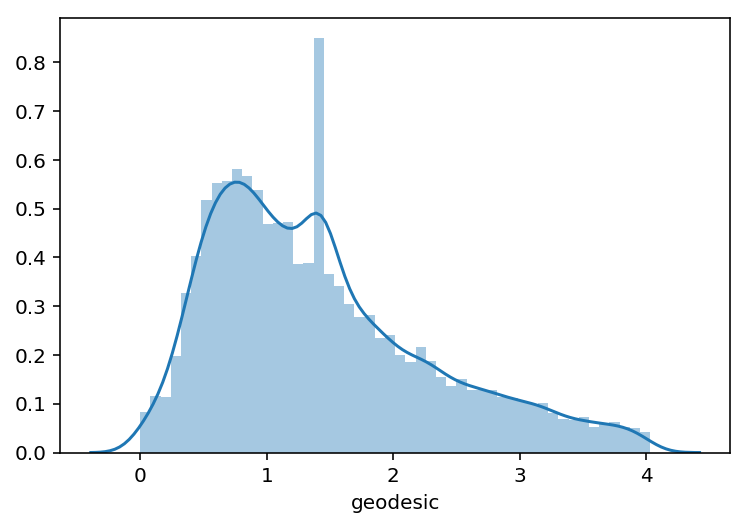

In [53]:
sns.distplot(train['geodesic'],bins=50)
plt.savefig('distplot.png')

((array([-3.9167234 , -3.69733025, -3.57713869, ...,  3.57713869,
          3.69733025,  3.9167234 ]),
  array([1.25608391e-04, 2.13559841e-04, 2.95258741e-04, ...,
         4.02528592e+00, 4.02884029e+00, 4.03171482e+00])),
 (0.8431923934714649, 1.4276089057565295, 0.9666771412128726))

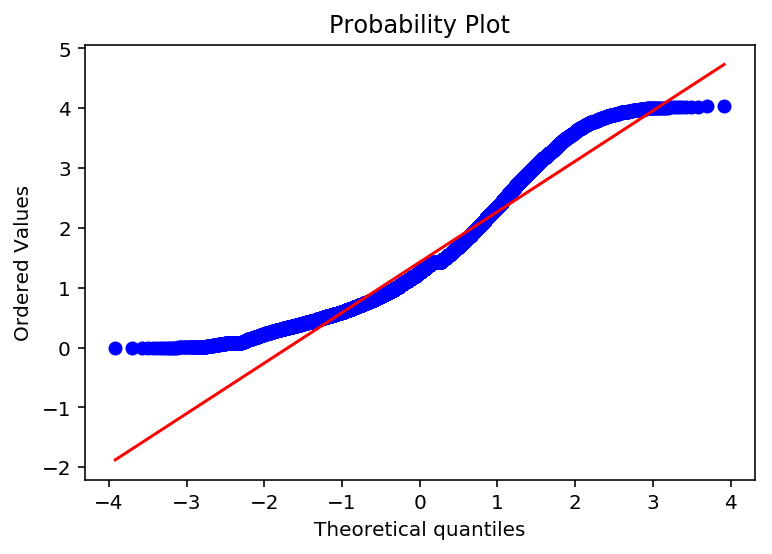

In [54]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)
# plt.savefig('qq prob plot.png')

In [55]:
#Normalization
train['geodesic'] = (train['geodesic'] - min(train['geodesic']))/(max(train['geodesic']) - min(train['geodesic']))
test['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) - min(test['geodesic']))

In [56]:
train['geodesic'].var()

0.046790346187628305

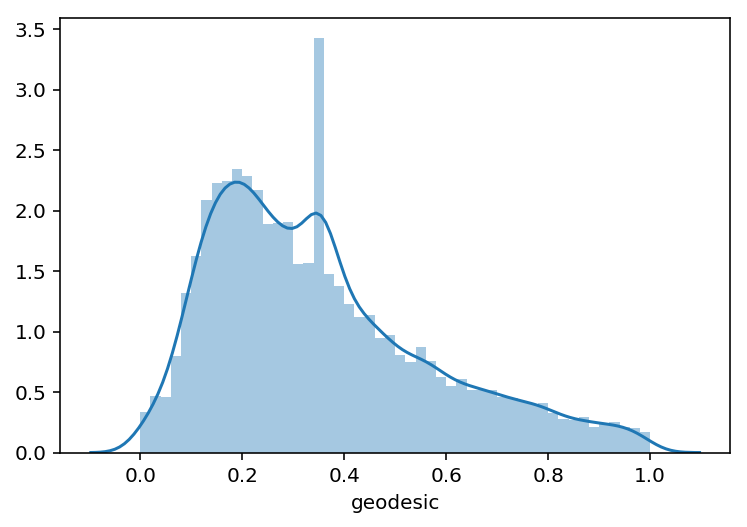

In [57]:
sns.distplot(train['geodesic'],bins=50)
plt.savefig('distplot.png')

((array([-3.9167234 , -3.69733025, -3.57713869, ...,  3.57713869,
          3.69733025,  3.9167234 ]),
  array([0.00000000e+00, 2.18155782e-05, 4.20802669e-05, ...,
         9.98405368e-01, 9.99287000e-01, 1.00000000e+00])),
 (0.20914640608864374, 0.3540745904578369, 0.9666771412128725))

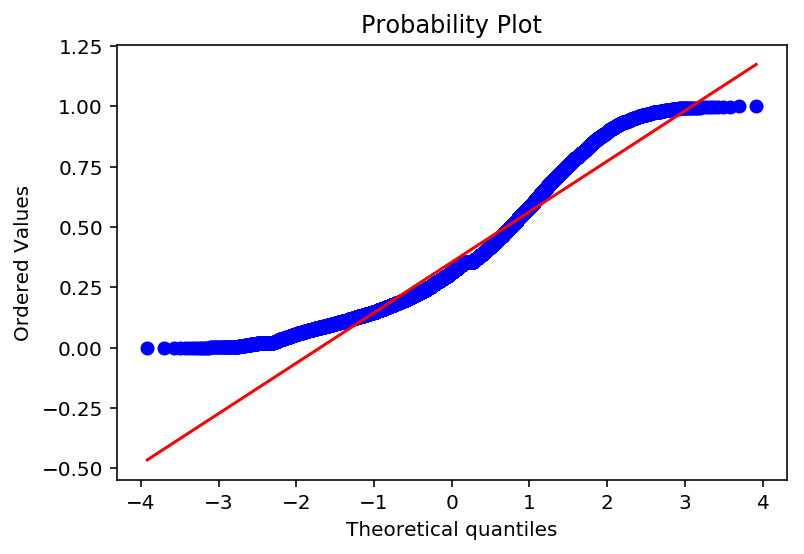

In [58]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)
# plt.savefig('qq prob plot.png')

In [59]:
df4=train.copy()
train=df4.copy()
f4=test.copy()
test=f4.copy()

In [60]:
train=train.drop(['passenger_count_2'],axis=1)
test=test.drop(['passenger_count_2'],axis=1)

In [0]:
#Splitting train into train and validation subsets
X_train y_train--are train subset
X_test y_test--are validation subset

In [61]:
X = train.drop('fare_amount',axis=1).values
y = train['fare_amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(train.shape, X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(15444, 20) (11583, 19) (3861, 19) (11583,) (3861,)


In [62]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))

In [0]:
#Multiple Linear Regression

In [64]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.42484893836110715


R^2: 0.43325042419225956
Root Mean Squared Error: 2.979552366547074
<<<------------------- Training Data Score --------------------->

r square   0.42328875587041104
Adjusted r square:0.42234111999404134
MAPE:24.53183882065928
MSE: 9.032344401295232
RMSE: 3.005385898898049


RMSLE: 0.27184025443669585

<<<------------------- Test Data Score --------------------->

r square   0.43325042419225956
Adjusted r square:0.43044692459831346
MAPE:24.40522544383061
MSE: 8.87773230499627
RMSE: 2.979552366547074
RMSLE: 0.27099311973776447
[ 2.18568400e-01  4.66174676e-01 -3.60660764e-02  8.82251378e-02
 -2.61941681e-01 -4.86456979e-01 -3.62471388e-01 -2.52327244e-01
 -3.29969844e-01 -4.47079642e-01 -1.67280648e-02 -4.65889570e-01
 -1.40568282e-01 -8.88375107e-03  2.64389531e-01  1.00963660e+00
  1.12096415e+00  1.42837386e+00  1.16063781e+01]


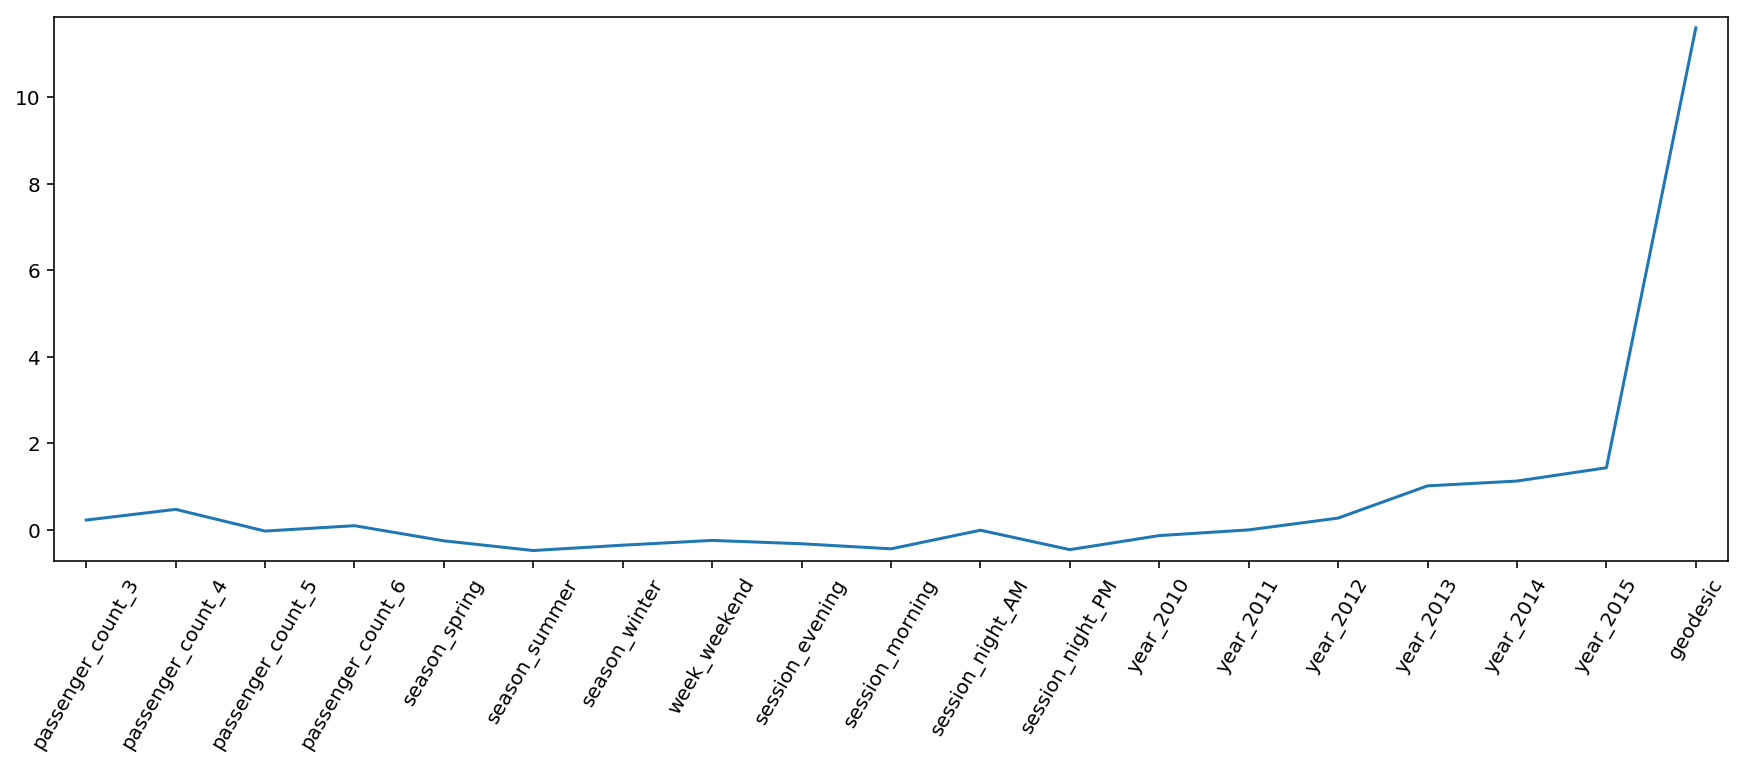

In [65]:
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), reg_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

In [66]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[ -8.96296363  -8.07945839  -8.89175103 -10.14501476  -8.99027789]
Average 5-Fold CV Score: -9.013893139277483


In [0]:
#Ridge Regression

In [67]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 0.0024420530945486497, 'max_iter': 500, 'normalize': True}
Best score is 0.4248516397104168


In [0]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.0005428675439323859, normalize=True,max_iter = 500)

# Fit the regressor to the data
ridge.fit(X_train,y_train)

# Compute and print the coefficients
ridge_coef = ridge.coef_
print(ridge_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), ridge_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
# plt.savefig('ridge coefficients')
plt.show()
test_scores(ridge)

In [0]:
#Lasso Regression

In [0]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision lasso classifier: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2')

# Fit it to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

In [0]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.00021209508879201905, normalize=False,max_iter = 500)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.ylim(-1,10)
plt.plot(range(len(test.columns)), lasso_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('lasso coefficients')
plt.show()
test_scores(lasso)

In [0]:
# Decision Tree Regression

In [0]:
train.info()

In [0]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

In [0]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=2)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

In [0]:
# Random Forest Regression

In [0]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

In [0]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=100, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=9, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

In [0]:
from sklearn.model_selection import cross_val_score
# Create a random forest regression object: Forest
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=12, bootstrap=True)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(Forest,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

In [0]:
## Improving accuracy using XGBOOST
- Improve Accuracy a) Algorithm Tuning b) Ensembles

In [0]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [0]:
dtrain,dtest,data_dmatrix

In [0]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

In [0]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

In [0]:
Xgb = XGBRegressor()
Xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(Xgb)

In [0]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

In [0]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)

In [0]:
#Finalize model
Create standalone model on entire training dataset
Save model for later use

In [0]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def score(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
    print('RMSLE:',rmsle(y_test,y_pred))
def scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    score(y,y_pred)
    print('RMSLE:',rmsle(y,y_pred))   

In [0]:
test.columns

In [0]:
train.columns

In [0]:
a=pd.read_csv('test.csv')

In [0]:
test_pickup_datetime=a['pickup_datetime']

In [0]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb1 feature importance')
plt.show()
scores(Xgb)

# Predictions
pred = Xgb.predict(test.values)
pred_results_wrt_date = pd.DataFrame({"pickup_datetime":test_pickup_datetime,"fare_amount" : pred})
pred_results_wrt_date.to_csv("predictions_xgboost.csv",index=False)

In [0]:
pred_results_wrt_date

In [0]:
# Save the model as a pickle in a file 
joblib.dump(Xgb, 'cab_fare_xgboost_model.pkl') 
  
# # Load the model from the file 
# Xgb_from_joblib = joblib.load('cab_fare_xgboost_model.pkl')  